# WBC Segmentation - K-Means vs Fuzzy C-Means

trying to segment white blood cells (nucleus and cytoplasm) using two clustering methods and see which one gives better boundaries

dataset from kaggle - blood cell images, has 3 folders: Train, Test-A, Test-B

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
from skfuzzy import cmeans
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

print('all good')

all good


## loading the dataset

In [2]:
# change this to wherever you extracted the archive folder
base = r'/home/patan/Downloads/archive/White_blood/archive'

train_dir  = os.path.join(base, 'Train')
test_a_dir = os.path.join(base, 'Test-A')
test_b_dir = os.path.join(base, 'Test-B')

def get_imgs(folder):
    exts = ('.jpg', '.jpeg', '.png')
    all_paths = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(exts):
                all_paths.append(os.path.join(root, f))
    return all_paths

train_imgs  = get_imgs(train_dir)
test_a_imgs = get_imgs(test_a_dir)
test_b_imgs = get_imgs(test_b_dir)

print('train:', len(train_imgs))
print('test-a:', len(test_a_imgs))
print('test-b:', len(test_b_imgs))

train: 10175
test-a: 4339
test-b: 2119


## quick look at some images

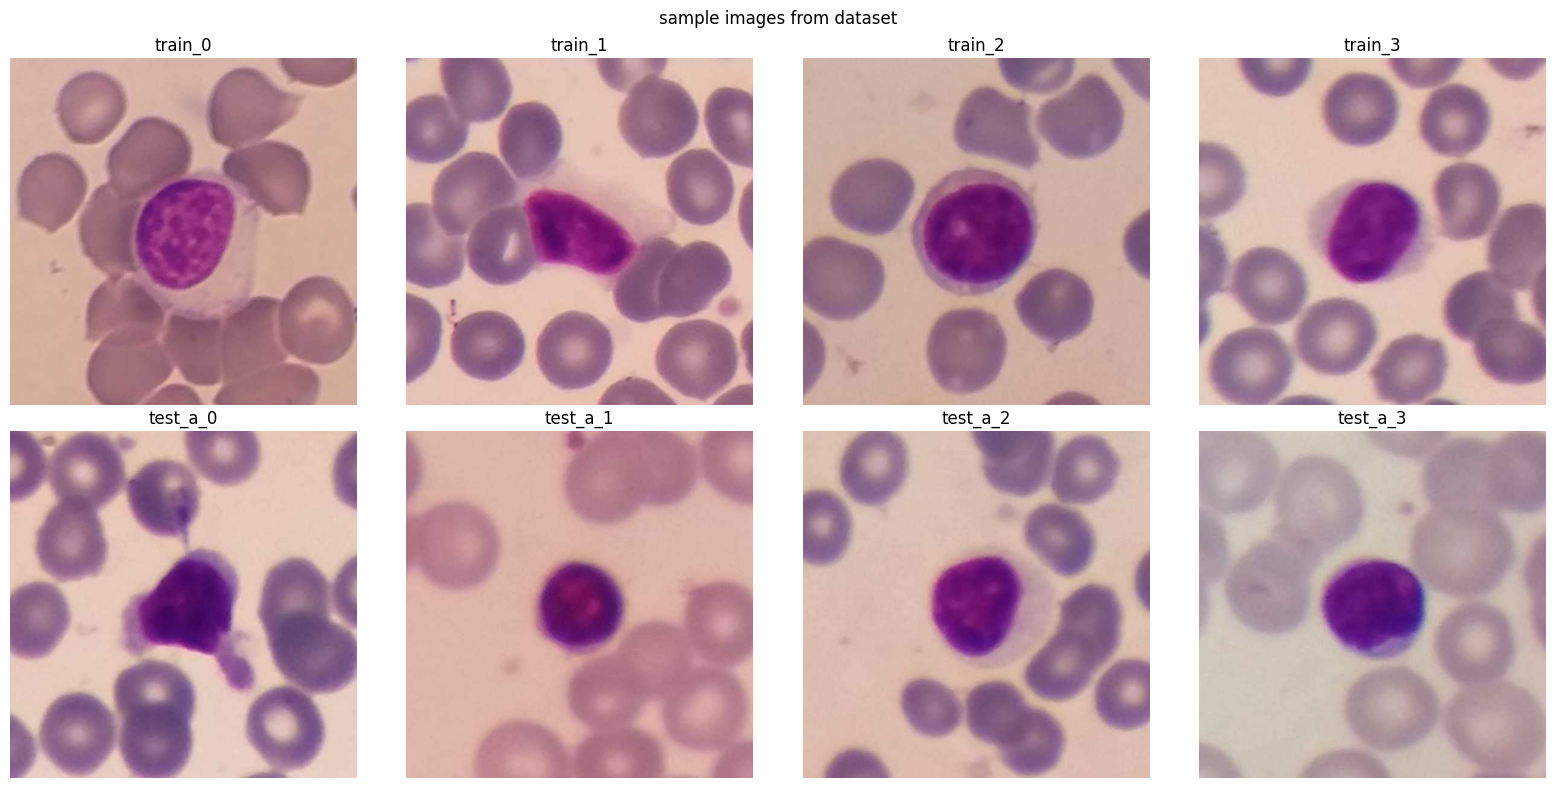

In [3]:
def read_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    axes[0][i].imshow(read_img(train_imgs[i]))
    axes[0][i].set_title(f'train_{i}')
    axes[0][i].axis('off')

for i in range(4):
    axes[1][i].imshow(read_img(test_a_imgs[i]))
    axes[1][i].set_title(f'test_a_{i}')
    axes[1][i].axis('off')

plt.suptitle('sample images from dataset')
plt.tight_layout()
plt.show()

In [4]:
def preprocess(path):
    img = read_img(path)
    img = cv2.resize(img, (256, 256))
    pixels = img.reshape(-1, 3).astype(np.float32) / 255.0
    return img, pixels

# test it
img, pix = preprocess(train_imgs[0])
print('image shape:', img.shape)
print('pixel array shape:', pix.shape)  # should be (65536, 3)

image shape: (256, 256, 3)
pixel array shape: (65536, 3)


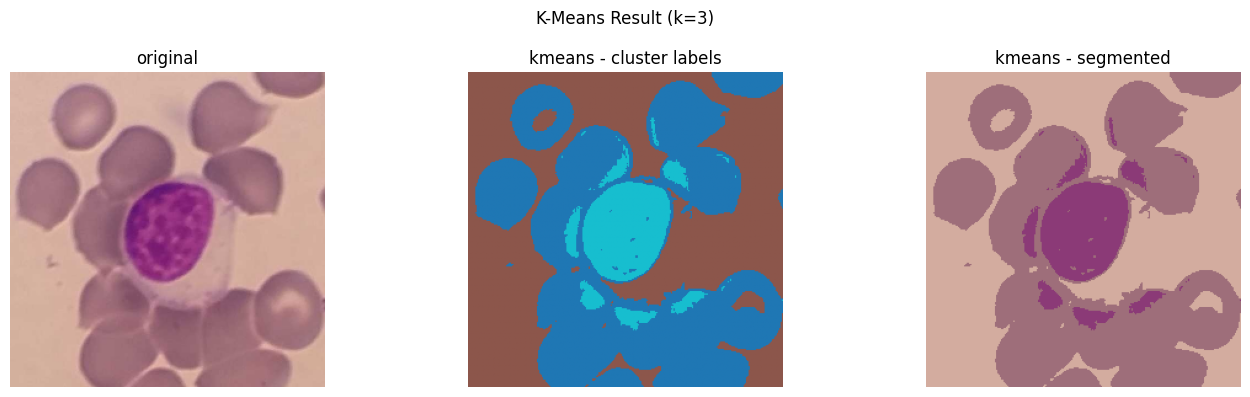

In [5]:
def apply_kmeans(img, pixels, k=3):
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(pixels)
    
    centers = (km.cluster_centers_ * 255).astype(np.uint8)
    seg_pixels = centers[labels]
    
    h, w = img.shape[:2]
    seg_img = seg_pixels.reshape(h, w, 3)
    label_map = labels.reshape(h, w)
    
    return label_map, seg_img, km


img, pix = preprocess(train_imgs[0])
km_labels, km_seg, km_model = apply_kmeans(img, pix)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].imshow(img)
axes[0].set_title('original')
axes[0].axis('off')

axes[1].imshow(km_labels, cmap='tab10')
axes[1].set_title('kmeans - cluster labels')
axes[1].axis('off')

axes[2].imshow(km_seg)
axes[2].set_title('kmeans - segmented')
axes[2].axis('off')

plt.suptitle('K-Means Result (k=3)')
plt.tight_layout()
plt.show()

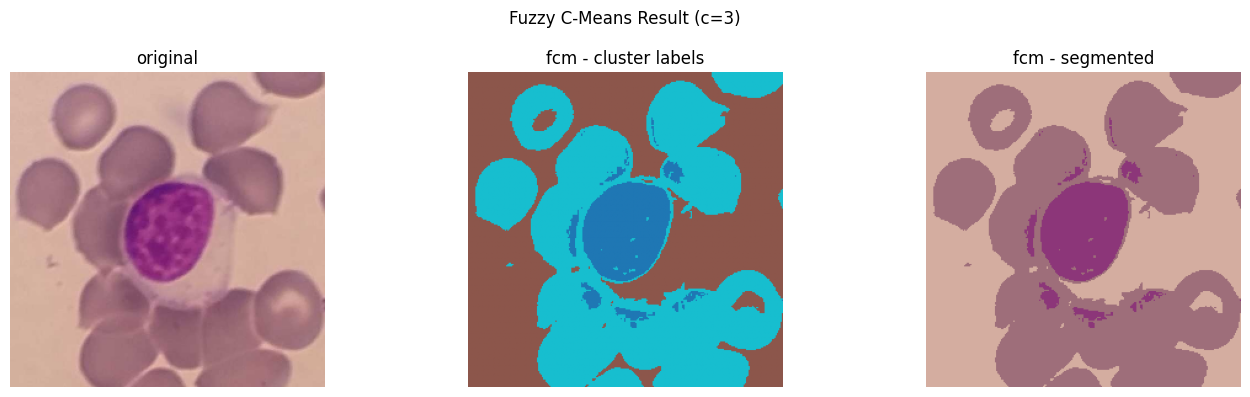

In [6]:
def apply_fcm(img, pixels, c=3, m=2.0):
    # skfuzzy needs shape (features, samples) so transpose
    data = pixels.T
    
    centers, u, u0, d, jm, p, fpc = cmeans(
        data, c=c, m=m, error=0.005, maxiter=300
    )
    
    # get hard labels from membership (argmax)
    labels = np.argmax(u, axis=0)
    
    centers_uint8 = np.clip(centers * 255, 0, 255).astype(np.uint8)
    seg_pixels = centers_uint8[labels]
    
    h, w = img.shape[:2]
    seg_img = seg_pixels.reshape(h, w, 3)
    label_map = labels.reshape(h, w)
    
    return label_map, u, seg_img, centers


fcm_labels, membership, fcm_seg, fcm_centers = apply_fcm(img, pix)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].imshow(img)
axes[0].set_title('original')
axes[0].axis('off')

axes[1].imshow(fcm_labels, cmap='tab10')
axes[1].set_title('fcm - cluster labels')
axes[1].axis('off')

axes[2].imshow(fcm_seg)
axes[2].set_title('fcm - segmented')
axes[2].axis('off')

plt.suptitle('Fuzzy C-Means Result (c=3)')
plt.tight_layout()
plt.show()

## Membership maps - the main advantage of FCM

this is what makes FCM special - you can see exactly how much each pixel belongs to each cluster. brighter = higher membership

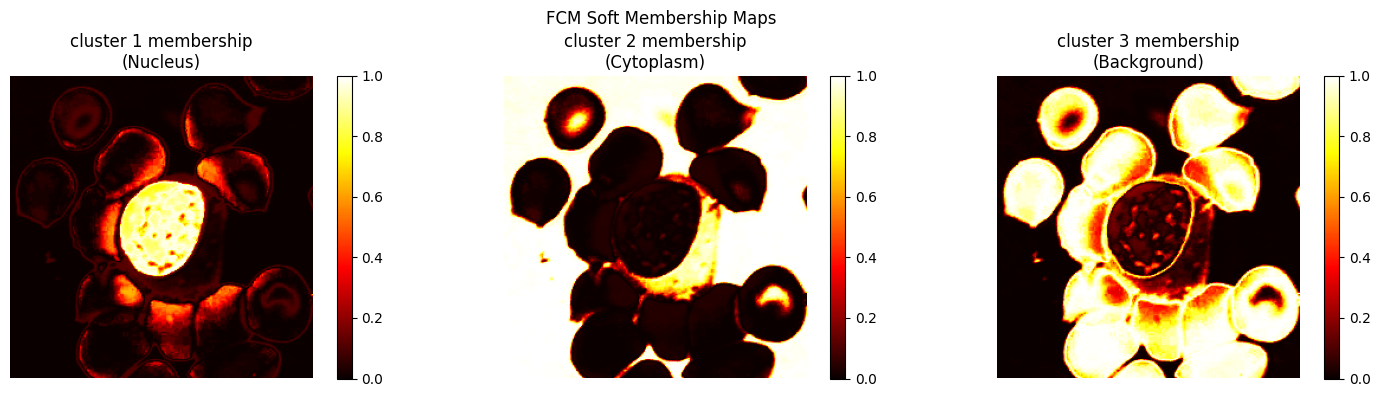

note: pixels at boundaries have mixed values - that is the soft clustering advantage


In [7]:
h, w = img.shape[:2]
names = ['Nucleus', 'Cytoplasm', 'Background']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for c in range(3):
    mem = membership[c].reshape(h, w)
    im = axes[c].imshow(mem, cmap='hot', vmin=0, vmax=1)
    axes[c].set_title(f'cluster {c+1} membership\n({names[c]})')
    axes[c].axis('off')
    plt.colorbar(im, ax=axes[c])

plt.suptitle('FCM Soft Membership Maps')
plt.tight_layout()
plt.show()

print('note: pixels at boundaries have mixed values - that is the soft clustering advantage')

## Side by side comparison

comparing both methods on same image, also showing difference map (red = pixels where they disagree)

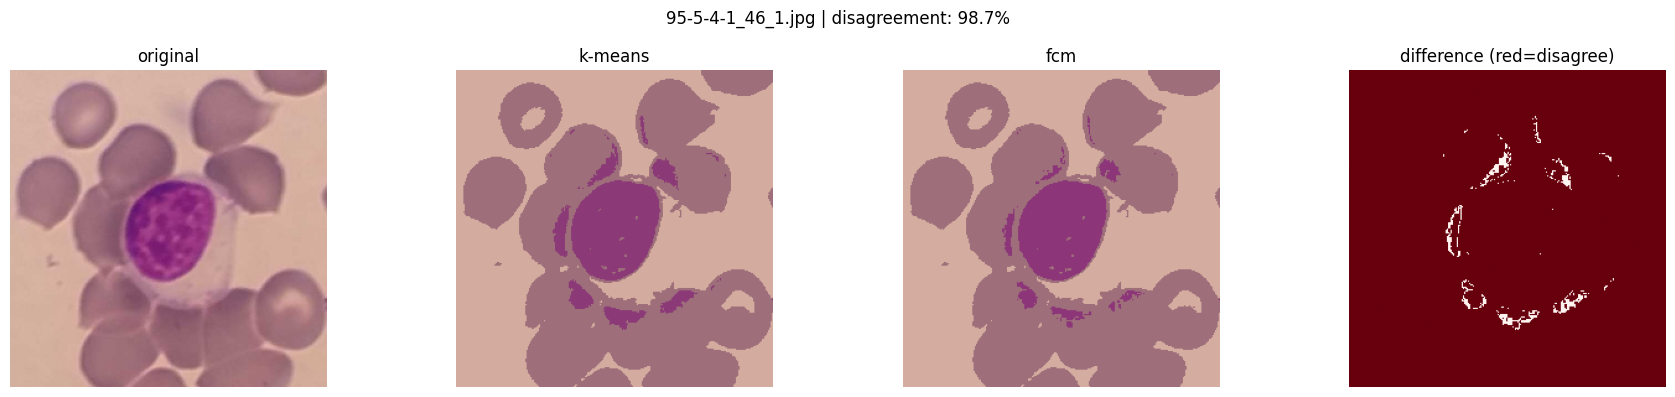

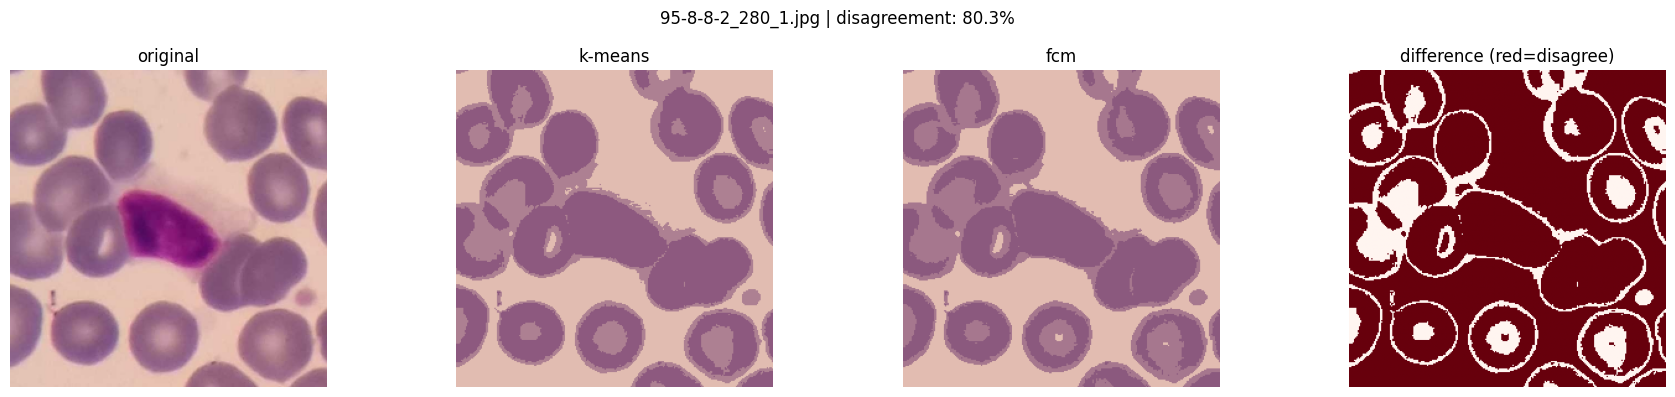

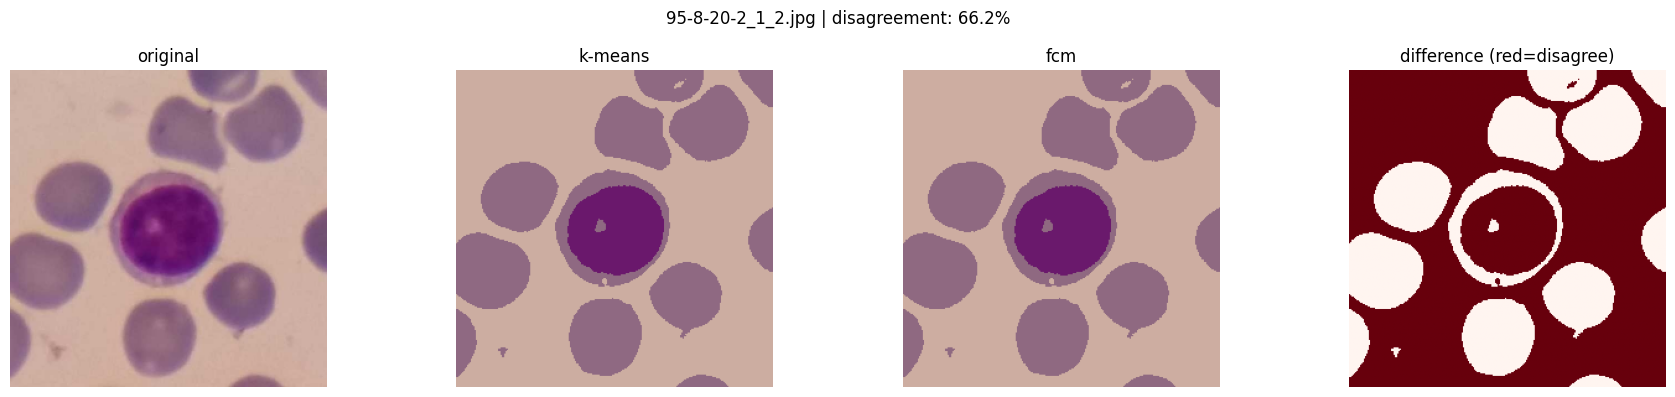

In [8]:
def compare_on_image(path):
    img, pix = preprocess(path)
    km_lab, km_seg, _ = apply_kmeans(img, pix)
    fcm_lab, _, fcm_seg, _ = apply_fcm(img, pix)
    
    diff = (km_lab != fcm_lab).astype(np.uint8) * 255
    disagree_pct = 100 * (km_lab != fcm_lab).sum() / km_lab.size
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    axes[0].imshow(img);    axes[0].set_title('original');    axes[0].axis('off')
    axes[1].imshow(km_seg); axes[1].set_title('k-means');     axes[1].axis('off')
    axes[2].imshow(fcm_seg);axes[2].set_title('fcm');         axes[2].axis('off')
    axes[3].imshow(diff, cmap='Reds'); axes[3].set_title('difference (red=disagree)'); axes[3].axis('off')
    
    plt.suptitle(f'{os.path.basename(path)} | disagreement: {disagree_pct:.1f}%')
    plt.tight_layout()
    plt.show()

# run on a few images
for p in train_imgs[:3]:
    compare_on_image(p)

## Finding the right number of clusters - Elbow method

just wanted to double check that k=3 makes sense

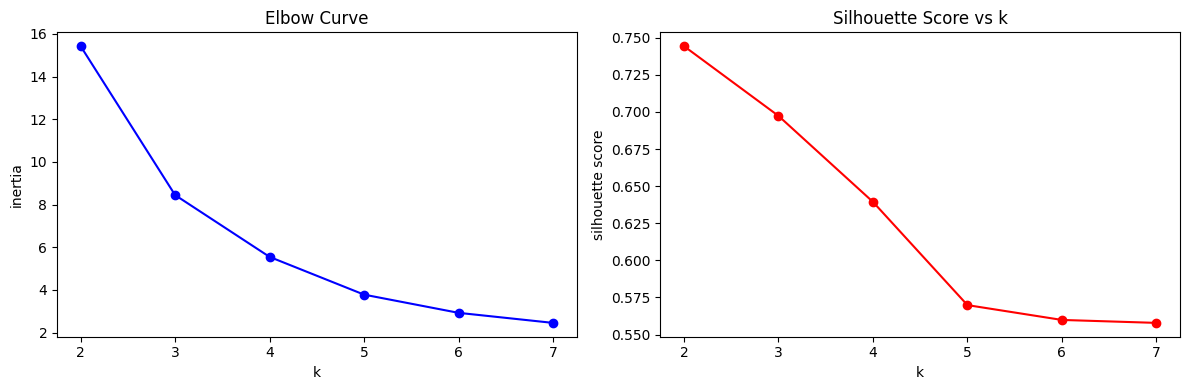

best k according to silhouette: 2


In [9]:
img, pix = preprocess(train_imgs[0])

# using a sample of pixels since full image takes forever
idx = np.random.choice(len(pix), 2000, replace=False)
pix_sample = pix[idx]

inertias = []
sil_scores = []
k_vals = list(range(2, 8))

for k in k_vals:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    lab = km.fit_predict(pix_sample)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(pix_sample, lab))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_vals, inertias, 'bo-')
ax1.set_xlabel('k')
ax1.set_ylabel('inertia')
ax1.set_title('Elbow Curve')

ax2.plot(k_vals, sil_scores, 'ro-')
ax2.set_xlabel('k')
ax2.set_ylabel('silhouette score')
ax2.set_title('Silhouette Score vs k')

plt.tight_layout()
plt.show()

best_k = k_vals[np.argmax(sil_scores)]
print(f'best k according to silhouette: {best_k}')

## Silhouette scores - kmeans vs fcm

higher silhouette = better cluster separation

In [10]:
km_scores = []
fcm_scores = []

for p in train_imgs[:5]:
    img, pix = preprocess(p)
    
    idx = np.random.choice(len(pix), 1000, replace=False)
    s = pix[idx]
    
    km = KMeans(n_clusters=3, random_state=0, n_init=10)
    km_lab = km.fit_predict(s)
    km_sil = silhouette_score(s, km_lab)
    km_scores.append(km_sil)
    
    _, u, *_ = cmeans(s.T, c=3, m=2.0, error=0.005, maxiter=300)
    fcm_lab = np.argmax(u, axis=0)
    fcm_sil = silhouette_score(s, fcm_lab)
    fcm_scores.append(fcm_sil)
    
    print(f'{os.path.basename(p):30s}  kmeans={km_sil:.4f}  fcm={fcm_sil:.4f}')

print()
print(f'avg kmeans silhouette : {np.mean(km_scores):.4f}')
print(f'avg fcm silhouette    : {np.mean(fcm_scores):.4f}')

95-5-4-1_46_1.jpg               kmeans=0.7348  fcm=0.7288
95-8-8-2_280_1.jpg              kmeans=0.6148  fcm=0.5909
95-8-20-2_1_2.jpg               kmeans=0.8073  fcm=0.8073
95-8-20-3_127_1.jpg             kmeans=0.6974  fcm=0.6973
95-8-8-2_197_1.jpg              kmeans=0.6273  fcm=0.6283

avg kmeans silhouette : 0.6963
avg fcm silhouette    : 0.6905


## Boundary accuracy comparison

using morphological gradient to extract boundaries from each segmentation then comparing with F1 score. since we dont have ground truth masks, using kmeans result as reference to measure how well fcm boundaries align

In [11]:
def get_boundary(label_map):
    kernel = np.ones((3,3), np.uint8)
    d = cv2.dilate(label_map.astype(np.uint8), kernel)
    e = cv2.erode(label_map.astype(np.uint8), kernel)
    return (d - e).astype(bool)

def boundary_f1(pred_lab, ref_lab, tol=2):
    pb = get_boundary(pred_lab).astype(np.uint8)
    rb = get_boundary(ref_lab).astype(np.uint8)
    
    kernel = np.ones((2*tol+1, 2*tol+1), np.uint8)
    pb_d = cv2.dilate(pb, kernel)
    rb_d = cv2.dilate(rb, kernel)
    
    prec = (pb & rb_d).sum() / (pb.sum() + 1e-9)
    rec  = (rb & pb_d).sum() / (rb.sum() + 1e-9)
    f1   = 2*prec*rec / (prec+rec+1e-9)
    return prec, rec, f1


print(f'{"file":35s}  precision    recall    f1')
print('-'*65)

all_results = []
for p in test_a_imgs[:10]:
    img, pix = preprocess(p)
    km_lab, _, _ = apply_kmeans(img, pix)
    fcm_lab, _, _, _ = apply_fcm(img, pix)
    
    pr, rc, f1 = boundary_f1(fcm_lab, km_lab)
    all_results.append(f1)
    print(f'{os.path.basename(p):35s}  {pr:.4f}       {rc:.4f}    {f1:.4f}')

print('-'*65)
print(f'mean boundary f1: {np.mean(all_results):.4f}')

file                                 precision    recall    f1
-----------------------------------------------------------------
95-8-6-1_362_1.jpg                   0.8273       0.9768    0.8959
95-8-22-3_62_2.jpg                   1.0000       1.0000    1.0000
95-8-17-1_154_2.jpg                  1.0000       0.9998    0.9999
95-8-22-3_78_1.jpg                   1.0000       1.0000    1.0000
95-8-27-1_262_3.jpg                  0.9914       0.9979    0.9946
95-8-6-1_594_1.jpg                   0.6585       0.9932    0.7919
95-8-22-5_30_1.jpg                   0.9983       1.0000    0.9992
95-9-1-2_17_1.jpg                    0.5429       0.9869    0.7004
95-8-27-1_207_2.jpg                  0.7443       0.9896    0.8496
95-8-17-3_111_1.jpg                  1.0000       0.9982    0.9991
-----------------------------------------------------------------
mean boundary f1: 0.9231


## Speed comparison on Test-A and Test-B

In [12]:
def check_speed(img_paths, name, n=10):
    paths = img_paths[:n]
    km_t, fcm_t = [], []
    
    for p in paths:
        img, pix = preprocess(p)
        
        t = time.time()
        apply_kmeans(img, pix)
        km_t.append(time.time()-t)
        
        t = time.time()
        apply_fcm(img, pix)
        fcm_t.append(time.time()-t)
    
    print(f'\n{name} ({len(paths)} images):')
    print(f'  kmeans avg: {np.mean(km_t):.3f}s per image')
    print(f'  fcm avg:    {np.mean(fcm_t):.3f}s per image')
    print(f'  fcm is ~{np.mean(fcm_t)/np.mean(km_t):.1f}x slower')

check_speed(test_a_imgs, 'Test-A')
check_speed(test_b_imgs, 'Test-B')


Test-A (10 images):
  kmeans avg: 0.278s per image
  fcm avg:    1.651s per image
  fcm is ~5.9x slower

Test-B (10 images):
  kmeans avg: 0.254s per image
  fcm avg:    0.642s per image
  fcm is ~2.5x slower


## Summary table

In [13]:
summary = {
    'Property':        ['Cluster type', 'Pixel assignment',          'Boundary',    'Output',                   'Speed',  'Noise sensitivity'],
    'K-Means':         ['Hard',         'one cluster only',          'Hard/sharp',  'label map',                'Fast',   'High'],
    'Fuzzy C-Means':   ['Soft',         'all clusters (membership)', 'Soft/smooth', 'membership maps',          'Slower', 'Lower'],
}

df = pd.DataFrame(summary)
df

Property           K-Means              Fuzzy C-Means
0       Cluster type              Hard                       Soft
1   Pixel assignment  one cluster only  all clusters (membership)
2           Boundary        Hard/sharp                Soft/smooth
3             Output         label map            membership maps
4              Speed              Fast                     Slower
5  Noise sensitivity              High                      Lower

## Final grid - all images together

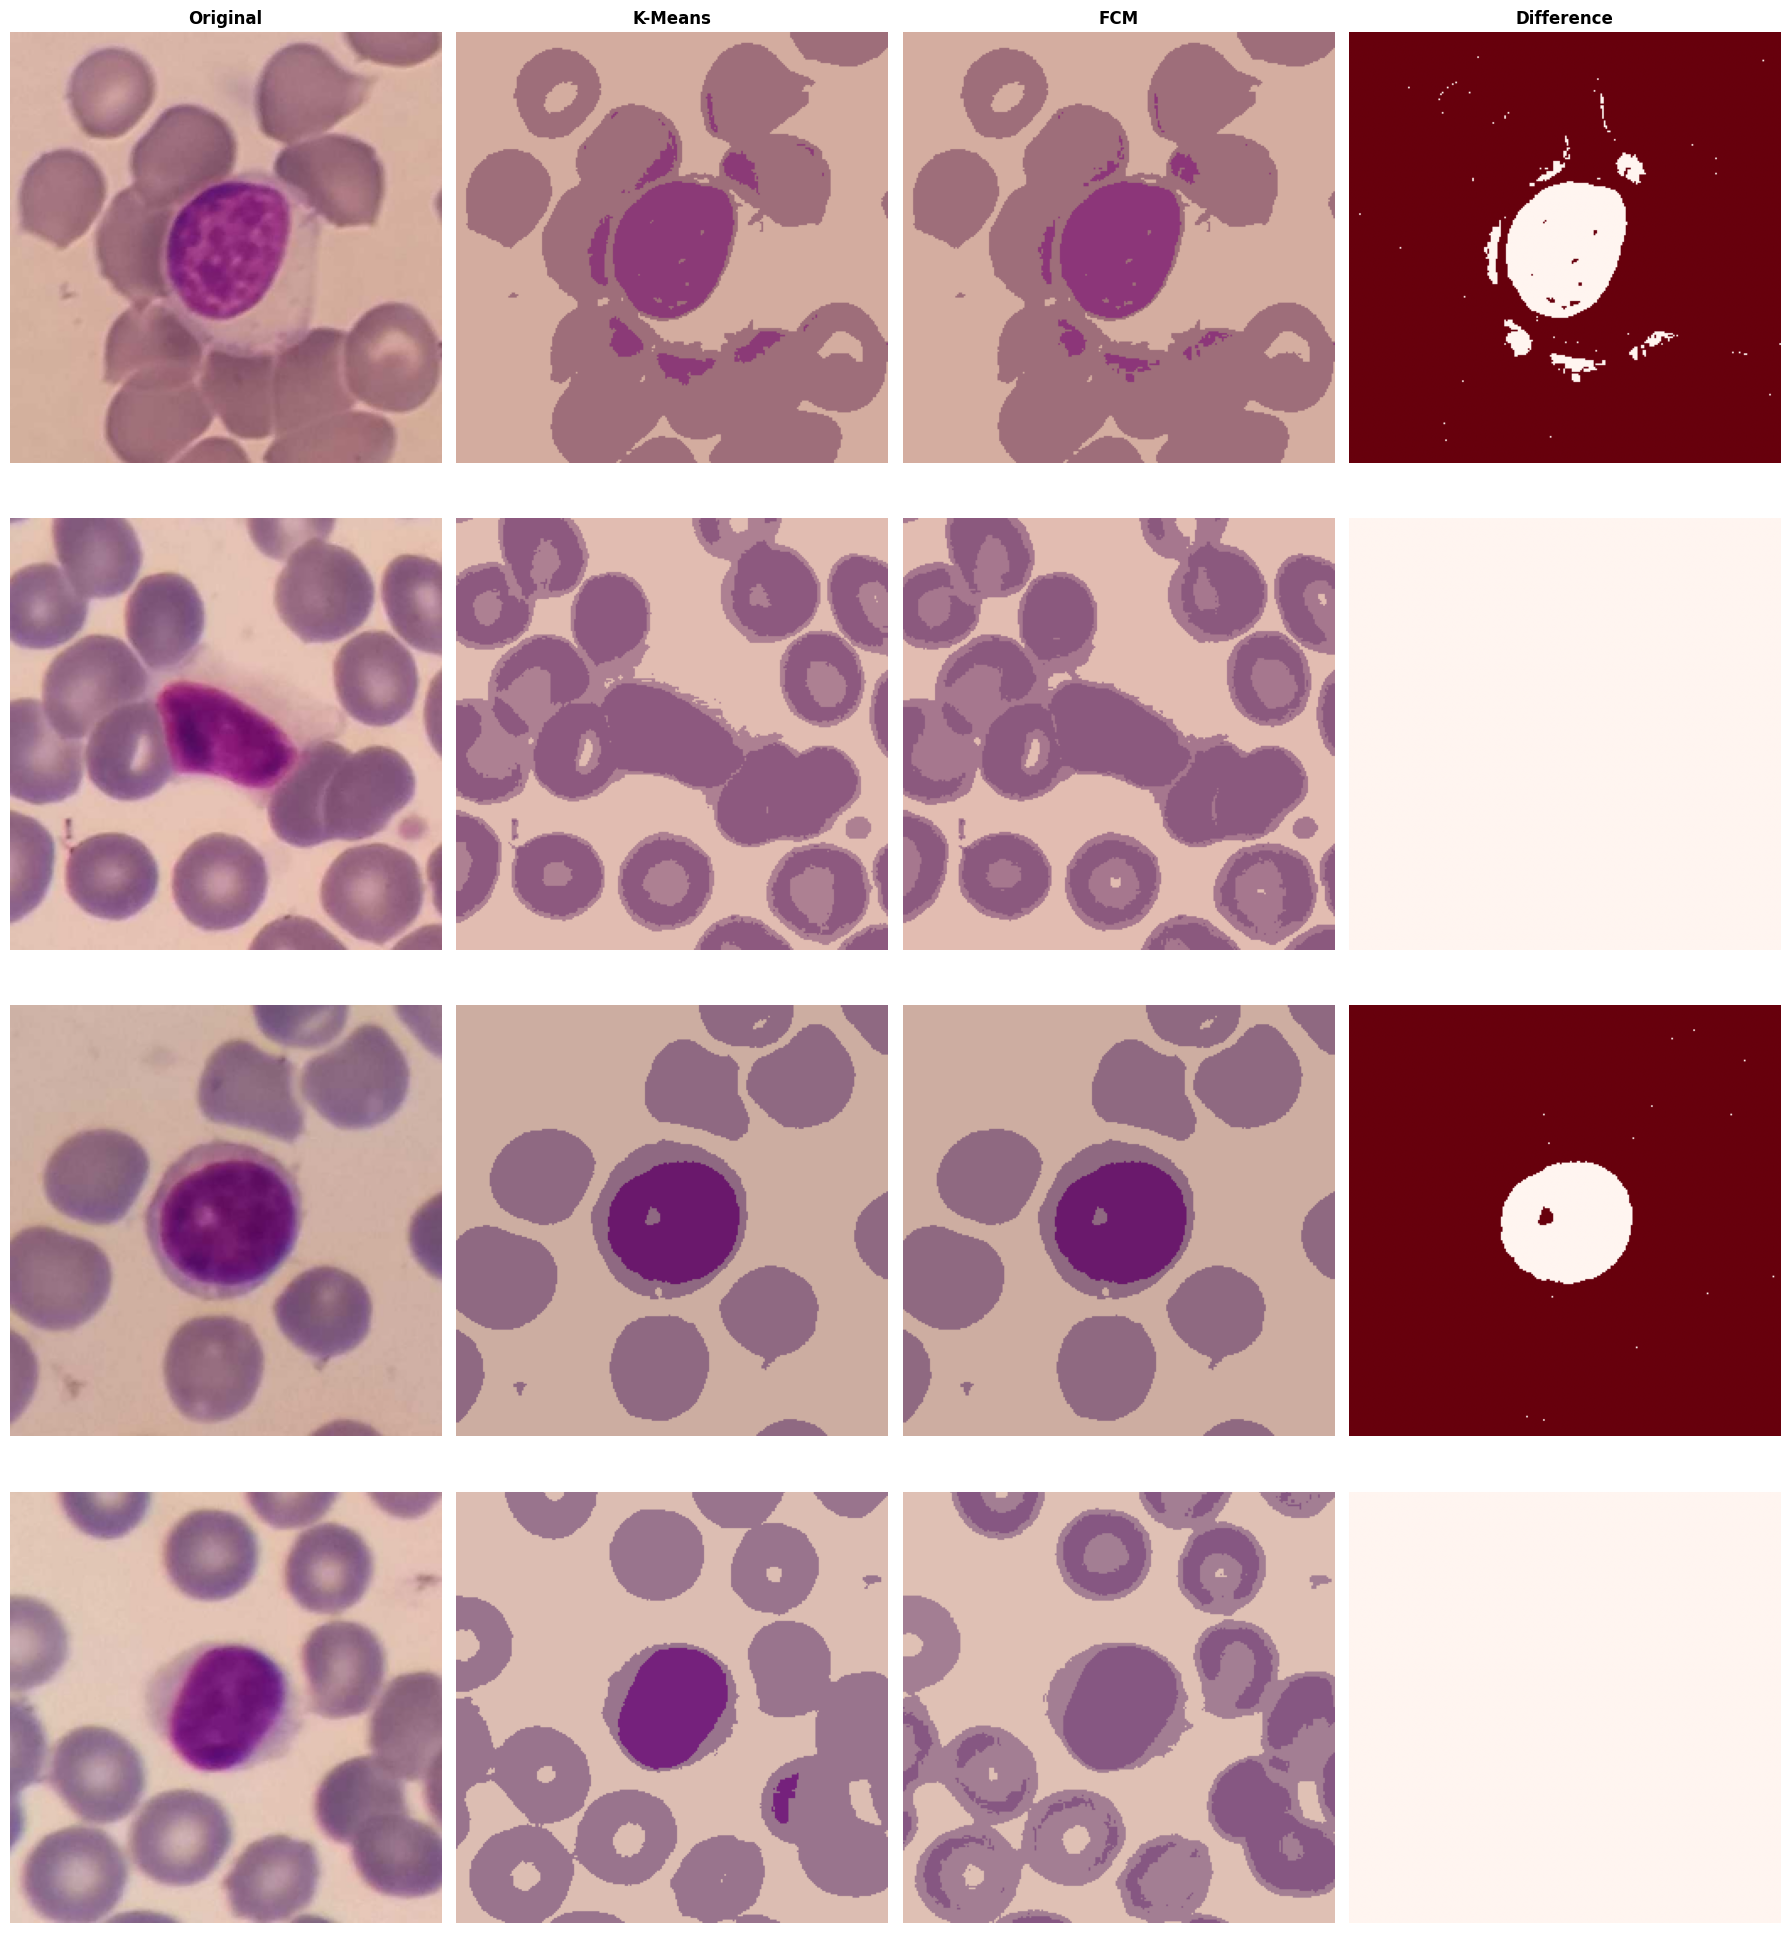

saved as segmentation_results.png


In [14]:
n = min(4, len(train_imgs))
fig, axes = plt.subplots(n, 4, figsize=(18, 5*n))

for col, title in enumerate(['Original', 'K-Means', 'FCM', 'Difference']):
    axes[0][col].set_title(title, fontsize=12, fontweight='bold')

for i in range(n):
    img, pix = preprocess(train_imgs[i])
    km_lab, km_seg, _ = apply_kmeans(img, pix)
    fcm_lab, _, fcm_seg, _ = apply_fcm(img, pix)
    diff = (km_lab != fcm_lab).astype(np.uint8) * 255
    
    axes[i][0].imshow(img);  axes[i][0].axis('off')
    axes[i][1].imshow(km_seg); axes[i][1].axis('off')
    axes[i][2].imshow(fcm_seg); axes[i][2].axis('off')
    axes[i][3].imshow(diff, cmap='Reds'); axes[i][3].axis('off')
    axes[i][0].set_ylabel(f'img {i+1}', fontsize=10)

plt.tight_layout()
plt.savefig('segmentation_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('saved as segmentation_results.png')